In [27]:
import numpy as np
import matplotlib.pyplot as plt

'''
Below we include some functions used for visualize data and calculate DVH. 
Please kindly follow citation suggestions in the README.md is you use below code in your research.
'''


def getDVH(dose_arr, mask, binsize=0.1, dmax=None):
    '''
    Calculate DVH per Region of Interest(ROI)
    dose_arr: dose array
    mask: mask of GTV/OAR
    binsize: bin size of the histogram, default 0.1
    dmax: maximum dose value for DVH calculation, using max(dose_arr)*110% if not given
    return: values of dose and DVH
    '''
    dosevalues = dose_arr[mask>0]
    
    if dmax is None:
        dmax = np.amax(dosevalues)*1.0
    hist, bin_edges = np.histogram(dosevalues, bins=np.arange(0,dmax,binsize))
    DVH = np.append(1, 1 - np.cumsum(hist)/len(dosevalues)) * 100
    return bin_edges, DVH

def NPZ2DVH(roi_dict, needed_mask, ref_ptv_name = None, ref_dose = 70, bin_size = 4, with_plt = True, save_plt_path = None):
    '''
    Calculate DVH per plan. 
    roi_dict: the data dictionary loaded from NPZ file
    needed_mask: the roi name list wanted to plot in one figure
    ref_ptv_name: if ref_ptv_name is not None, the dose will be scaled to match D97 (3 percentile dose value of ref ptv) to prescribed dose (i.e., ref_dose)
    ref_dose: prescribed dose of the reference ptv, only effective when ref_ptv_name is not None
    bin_size: bin size for the histogram
    with_plt: plt the figure or not
    save_plt_path: is not None, the plot figure will be saved to the path
    
    return: dvh_dict: the dictionary of all dvh values
    '''
    
    if roi_dict['dose'].max() > 200:
        dose_arr = roi_dict['dose'] * roi_dict['dose_scale'] 
    
    if dose_arr.max() < 10:
        dose_arr = 80 / dose_arr.max()  * dose_arr

    if ref_ptv_name is not None:
        ptv = roi_dict[ref_ptv_name]

        scale = ref_dose / np.percentile(dose_arr[ptv > 0.5], 3) 
    
        dose_arr = dose_arr * scale

    dvh_dict = {}

    for key in needed_mask:
        if roi_dict[key].max() == 0:
            continue
        #try:
        bin_edges_dose, DVH_dose = getDVH(dose_arr, roi_dict[key], binsize= bin_size, dmax=None)
        dvh_dict[key]  = {'dose': bin_edges_dose.tolist(), 'dvh': DVH_dose.tolist()}

        if with_plt:
            plt.plot(bin_edges_dose, DVH_dose,  label=key)
    if with_plt:
        plt.xlabel('Dose (Gy)')
        plt.ylabel('Volume (%)')  
        plt.legend(bbox_to_anchor=(1.01, 1.01))
        plt.show()
    return dvh_dict

def NormalizeImg(imgVol, maskVol = None):
    '''
        Normalize the data to be reasonable scale.
    '''
    i_min, i_max = np.percentile(imgVol, (0.5,99.5))
    if maskVol is not None:
        if maskVol.sum()>0:
            mask_slice_idx = np.nonzero(np.sum(imgVol, axis=(1,2)))[0]
            bg_slice_idx = [imgVol[i] for i in mask_slice_idx]
            i_min, i_max = np.percentile(bg_slice_idx, (0.5,99.5))

    imgVol_norm = (imgVol - i_min) / (i_max - i_min + 1e-10)
    imgVol_norm[imgVol_norm<0] = 0
    imgVol_norm[imgVol_norm>1] = 1
    imgVol_norm = np.uint8(imgVol_norm * 255)
    return imgVol_norm

def save_screenshot(npz_dict, PTV_name, masked_by_body = True, index = None): 
    
    '''
    save screenshot of the data loaded from npz, this can be used for quality checking
    '''
    
    if index is None:
        index = np.argmax(npz_dict['dose'].sum(axis = 1).sum(axis = 1))
    ptv = (npz_dict[PTV_name] > 0).astype('uint8') * 255
    img = NormalizeImg(npz_dict['img'])
    dose = NormalizeImg(npz_dict['dose'])

    if masked_by_body:

        body_indx = (npz_dict['Body'][index] > 0.5).astype('uint8') 
    else:
        body_indx = 1  

    angle_plate = npz_dict['angle_plate'] / npz_dict['angle_plate'].max() * 255

    beam_plate = npz_dict['beam_plate'] / npz_dict['beam_plate'].max() * 255
    
    img_x, img_y = img.shape[1:]
    save_img = np.zeros((img_x , img_y * 5), dtype = np.uint8)

    save_img[:, :img_y] = img[index] * body_indx
    save_img[:, img_y:img_y * 2] = dose[index] * body_indx
    save_img[:, img_y * 2:img_y * 3] = ptv[index] * body_indx

    save_img[:, img_y * 3:img_y * 4] = angle_plate * body_indx

    save_img[:, img_y * 4:img_y * 5] = beam_plate[index] *  body_indx
    return save_img

    

# 1. load the data in the npz format

In [2]:
data_path = 'data/HNC_001+A4Ac+MOS_25934.npz'
data_npz = np.load(data_path, allow_pickle=True)
data_dict = dict(data_npz)['arr_0'].item()

In [44]:
data_dict.keys()

dict_keys(['SpinalCord_05', 'BrainStem_03', 'Submand-PTV', 'Posterior_Neck', 'PharynxConst', 'Submandibular', 'Parotids', 'Parotids-PTV', 'PTVLowOPT', 'PTVMidOPT', 'PTV_Total', 'Lungs', 'RingPTVLow', 'RingPTVMid', 'RingPTVHigh', 'SubmandR-PTV', 'SubmandL-PTV', 'Thyroid-PTV', 'Larynx-PTV', 'OCavity-PTV', 'Mandible-PTV', 'PharConst-PTV', 'ParotdCon-PTV', 'ParotdIps-PTV', 'Low-Mid', 'Mid-High', 'High-Mid', 'ParotidIpsi', 'ParotidContra', 'Larynx', 'PTV_High', 'PTV_Mid', 'PTV_Low', 'BODY', 'PTV70', 'PTV 59.4', 'PTV 50.4', 'CTV 59.4', 'CTV 50.4', 'Brachial Plexus Left', 'Brachial Plexus Right', 'Brain', 'Brainstem', 'Brainstem Dahanca', 'Cochlea Left', 'Cochlea Right', 'Esophagus', 'Eye Globe Left', 'Eye Globe Right', 'Glottis', 'Glottis Dahanca', 'Inferior Pharyngeal Constrictor Muscle', 'Lips', 'Lung Left', 'Lung Right', 'Mandible', 'Middle Pharyngeal Constrictor Muscle', 'Optic Chiasm', 'Optic Nerve Left', 'Optic Nerve Right', 'Oral Cavity', 'Parotid Gland Left', 'Parotid Gland Right', '

### show the patient in Eclipse system 

The partcipants may not be able to show the plan in Eclipse system, here we can provide a screenshot. 

<img src="./figs/eclipse.png">

## 2. show data with matplotlib in three directions

Since the spacing is [2, 2.5, 2.5] for [z, x, y], some the image may look like a little stretched. 

[64.0, 47.0, 81.0] (128, 137, 175)


Text(0.5, 1.0, 'View from Coronal plane')

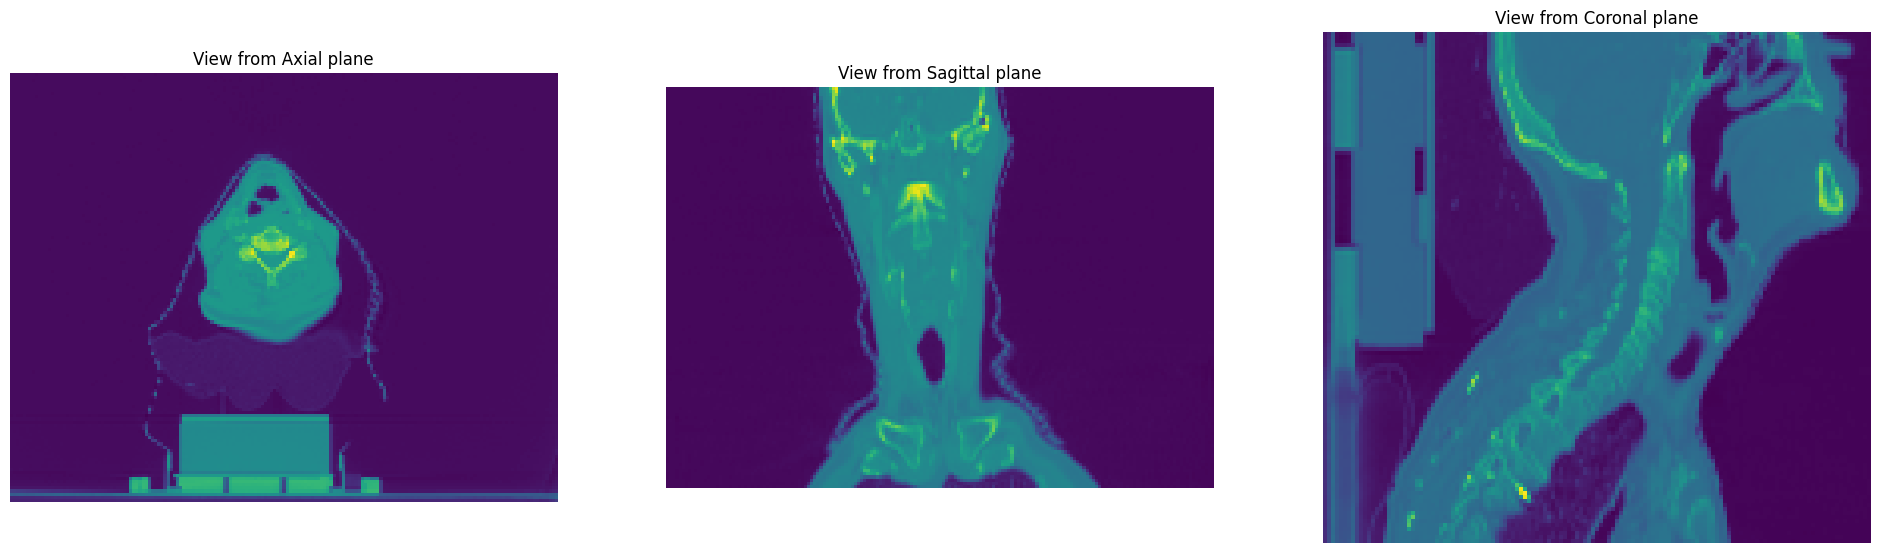

In [11]:

print (data_dict['isocenter'], data_dict['img'].shape)

fig = plt.figure(figsize=(24, 8))

ax1 = fig.add_subplot(131)
ax1.imshow(data_dict['img'][int(data_dict['isocenter'][0])])
ax1.axis('off')
ax1.set_title('View from Axial plane')

ax2 = fig.add_subplot(132)
ax2.imshow(data_dict['img'][::-1, int(data_dict['isocenter'][1]), :])
ax2.axis('off')
ax2.set_title('View from Sagittal plane')

ax3 = fig.add_subplot(133)
ax3.imshow(data_dict['img'][::-1, ::-1, int(data_dict['isocenter'][2])])
ax3.axis('off')
ax3.set_title('View from Coronal plane')


Text(0.5, 1.0, 'View from Coronal plane')

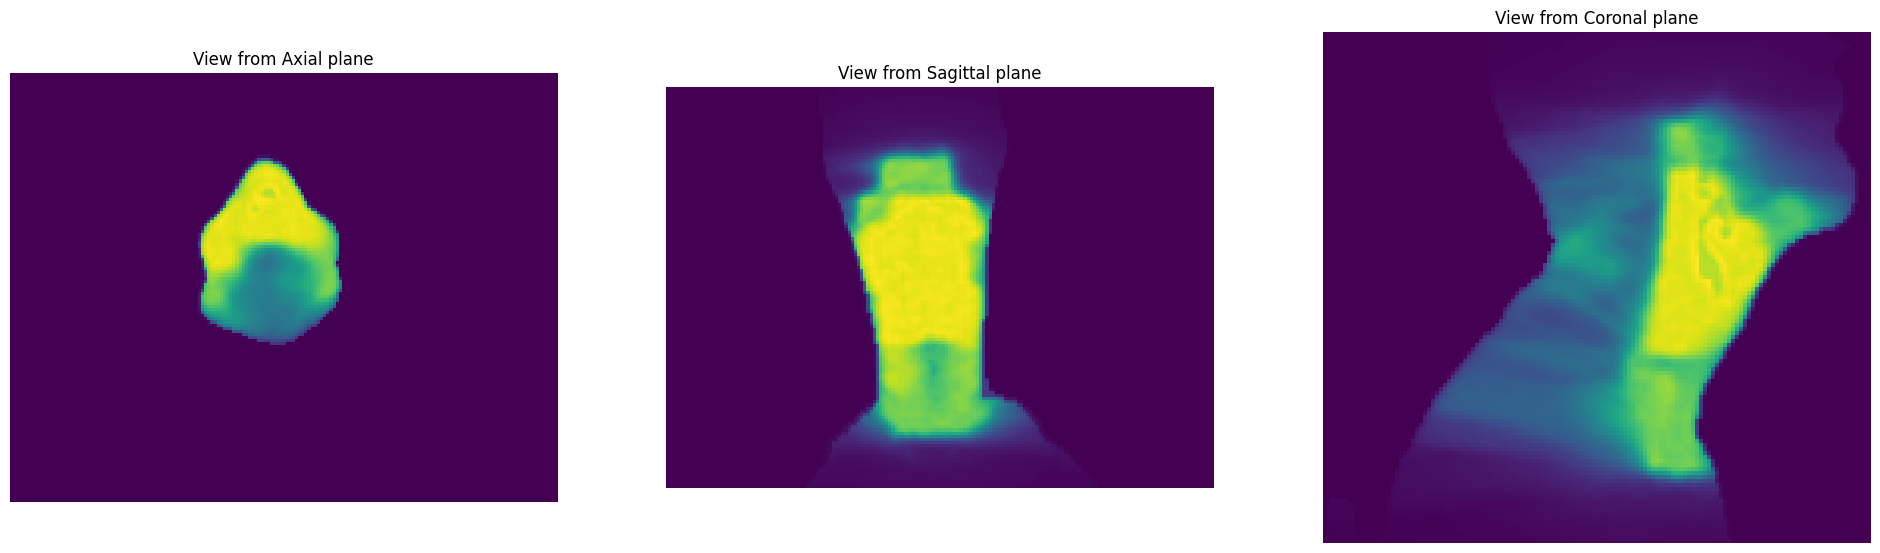

In [10]:
fig = plt.figure(figsize=(24, 8))

dose = data_dict['dose'] 
#dose = np.flip(data_dict['dose'], axis=0)
#dose = np.flip(dose, axis=2)

ax1 = fig.add_subplot(131)
ax1.imshow(dose[ int(data_dict['isocenter'][0])])
ax1.axis('off')
ax1.set_title('View from Axial plane')

ax2 = fig.add_subplot(132)
ax2.imshow(dose[::-1, int(data_dict['isocenter'][1]), :])
ax2.axis('off')
ax2.set_title('View from Sagittal plane')

ax3 = fig.add_subplot(133)
ax3.imshow(dose[::-1, ::-1, int(data_dict['isocenter'][2])])
ax3.axis('off')
ax3.set_title('View from Coronal plane')

## 3. Show the DVHs of the plan

Dose-Volume Histogram (DVH) is widely used in visualizing plan to check the quality. Please read our source code and some related resources online if you do not know about DVH. Here we provide the Python code to show DVHs with flexible needed masks. 

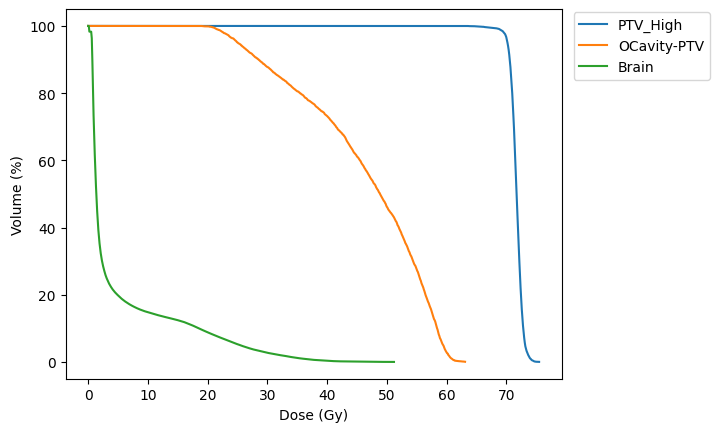

In [48]:
dvh_dict = NPZ2DVH(data_dict, needed_mask = ['PTV_High', 'OCavity-PTV', 'Brain'], ref_ptv_name = None, ref_dose = None, bin_size = 0.1, with_plt = True, save_plt_path = None)

## 4. screenshot with different image data 

To check data in a large scale, it would be great visualize multiple 3D data with 2D slices selected. 

(-0.5, 874.5, 136.5, -0.5)

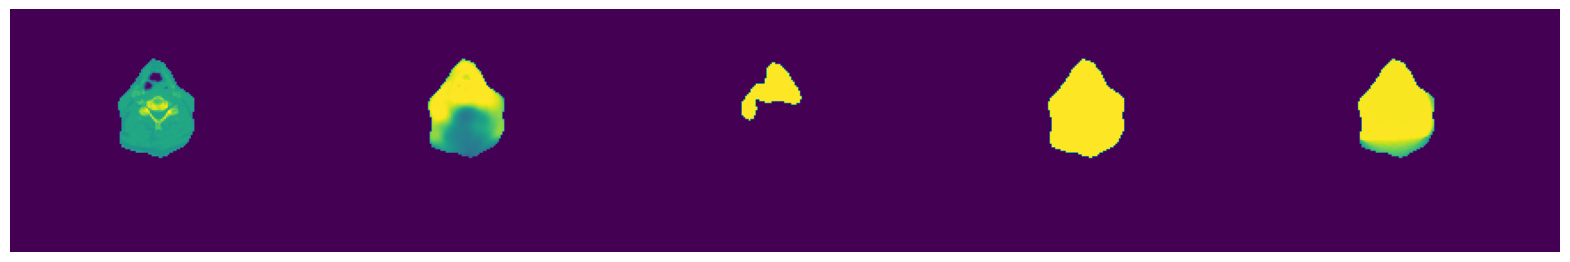

In [30]:
save_img = save_screenshot(data_dict, 'PTV70', index = int(data_dict['isocenter'][0]), masked_by_body = True)
fig = plt.figure(figsize=(20, 4))
plt.imshow(save_img)
plt.axis('off')

(-0.5, 754.5, 99.5, -0.5)

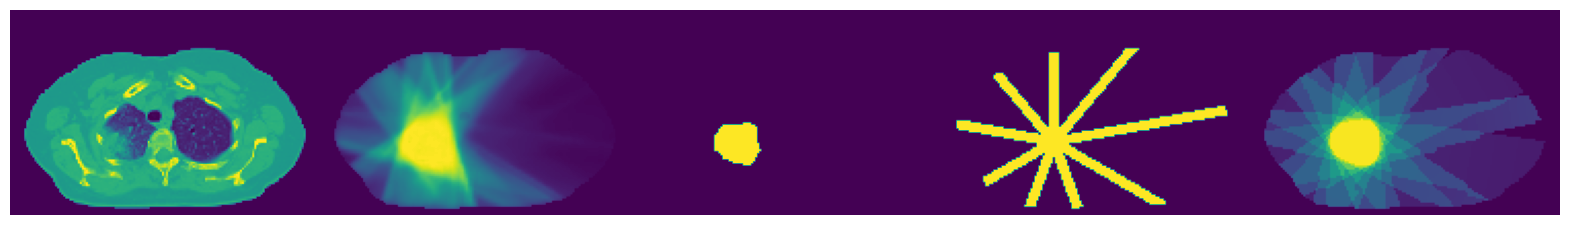

In [34]:
data_dict2 = np.load('data/0617-259694+imrt+MOS_33896.npz', allow_pickle=True)['arr_0'].item()

save_img = save_screenshot(data_dict2, 'PTV', index = int(data_dict['isocenter'][0]), masked_by_body = True)
fig = plt.figure(figsize=(20, 4))
plt.imshow(save_img)
plt.axis('off')

## 5. Understanding meta data and json files

### 5.1 the csv file

We provide an <a href="data_loader.py" _target='blank'>data loader</a> example for the PyTorch training. The <a href="meta_data.csv" _target='blank'>meta_data.csv</a> is the master file stored the npz data path and meta file information (which could be used for conditioning the model). 

In [2]:
import pandas as pd
df = pd.read_csv('meta_data.csv')
print (df)

       PID PlanID  isVMAT  site  cohort  phase  \
0  HNC_001   A4Ac    True     1       3  train   
1  HNC_001   A9Ag   False     1       3  train   

                          npz_path  
0  data/HNC_001+A4Ac+MOS_25934.npz  
1  data/HNC_001+A9Ag+MOS_25934.npz  


The `isVMAT` is binary indicates if the plan is VMAT or IMRT. `site` is the site index of either head-and-neck or lung. `cohort` is cohort index. Note that, different train/validation/test splits may have different cohorts. 

### 5.2 the json file

`Pat_Obj_dict.json` documents the RT structures **actually used** during the optimization when creating the **reference dose**. Note in the npz file, more structures can be included but some of them may not be used for optimization due to too small structures or too large overlapped with PTV. 

In [7]:
import json 

Pat_Obj_dict = json.load(open('Pat_Obj_dict.json'))
print (Pat_Obj_dict['0522c0003']['A4Ac'])

['SpinalCord', 'Parotids-PTV', 'Chiasm', 'Brain', 'OCavity-PTV', 'RingPTVHigh', 'Esophagus', 'PTVHighOPT', 'Cochlea_R', 'Lips', 'BrainStem_03', 'RingPTVMid', 'Mandible-PTV', 'PTVLow', 'ParotidIps-PTV', 'Pituitary', 'Mandible', 'RingPTVLow', 'Cochlea_L', 'Larynx', 'Eyes', 'OpticNerve_R', 'ParotidCon-PTV', 'Thyroid-PTV', 'Posterior_Neck', 'PharConst-PTV', 'OpticNerve_L', 'BrainStem', 'Larynx-PTV', 'PTVMidOPT', 'PharynxConst', 'SpinalCord_05', 'Parotids', 'Shoulders', 'Thyroid', 'Trachea', 'PTVMid', 'PTVLowOPT', 'OralCavity', 'Lungs']


`PTV_DICT.json` documents the **prescribed dose** of different PTVs used when creating the **reference plan**. We automatically extract the prescribed dose from the clinical plan if available to best keep clinical intent. For example, we extract the prescribed dose from the PTV names first, if the number is missing or error detected, we imput the prescribed dose with dose metrics (e.g., D95, D98) or procotol suggestion. 

The **prescribed dose** is provided as input data for all train/validation/test splits, so it could be used for the input of the AI model. 

In [13]:
PTV_DICT = json.load(open('PTV_DICT.json'))
PTV_DICT['0522c0003']

{'PTV_High': {'OPTName': 'PTVHighOPT', 'PDose': 70, 'RingName': 'RingPTVHigh'},
 'PTV_Low': {'MinusName': 'PTVLow-PTVMid',
  'OPTName': 'PTVLowOPT',
  'PDose': 54,
  'RingName': 'RingPTVLow',
  'StructName': 'PTVLow'},
 'PTV_Mid': {'MinusName': 'PTVMid-PTVHigh',
  'OPTName': 'PTVMidOPT',
  'PDose': 56,
  'RingName': 'RingPTVMid',
  'StructName': 'PTVMid'}}